# Multi-dimensional seismic reconstruction


Seismic data interpolation is such a processing step to regularize the irregularly sampled seismic traces onto regular grids. 

Commonly used multi-dimensional seismic reconstruction methods include 
1. sparsity-based (Fourier, Radon, wavelet, curvelet, etc)
2. prediction-based (prediction-error-filter, stationary/non-stationary prediction filter)
3. rank-based (rank-reduction method, damped rank-reduction method, optimally damped rank-reduction methods)
4. deep-learning-based (treating seismic data as an image and using computer vision techniques to restore missing data)

We will introduce sparsity-based and rank-based methods. For sparsity-based methods, we will introduce Fourier and Radon methods. For rank-based methods, we will introduced various rank-reduction (RR) methods, e.g., RR, DRR, ODRR.

The simple mathematical expression of interpolation is

$\mathbf{d}_{obs} = \mathbf{M} \mathbf{d}$,

where $\mathbf{d}_{obs}$ is the observed (incomplete) data, $\mathbf{M}$ is the sampling (mask) operator, $\mathbf{d}$ is the model (complete data). 

$\mathbf{M}$ is a block diagonal matrix:

\begin{equation}
\mathbf{M}=\left[ \begin{array}{ccccc}
\mathbf{I} & & & & \\
& \mathbf{I} & & & \\
& & \mathbf{O} & & \\
& & & \ddots & \\
& & & & \mathbf{I}
\end{array}\right]
\end{equation}
$\mathbf{I}$ means sampling a trace and $\mathbf{O}$ means missing a trace.


(300, 20, 20)


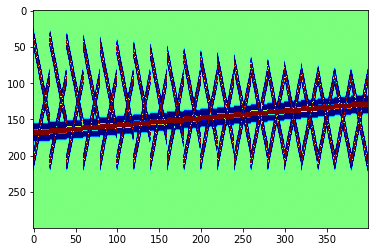

In [1]:
# Multi-dimensional reconstruction

import numpy as np
import matplotlib.pyplot as plt
import pydrr as pd #pd: DRR

## generate the synthetic data
a1=np.zeros([300,20])
[n,m]=a1.shape
a3=np.zeros([300,20])
a4=np.zeros([300,20])

k=-1;
a=0.1;
b=1;
pi=np.pi

ts=np.arange(-0.055,0.055+0.002,0.002)
b1=np.zeros([len(ts)])
b2=np.zeros([len(ts)])
b3=np.zeros([len(ts)])
b4=np.zeros([len(ts)])

for t in ts:
    k=k+1;
    b1[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));
    b2[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b3[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b4[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));

t1=np.zeros([m],dtype='int')
t3=np.zeros([m],dtype='int')
t4=np.zeros([m],dtype='int')
for i in range(m):
  t1[i]=np.round(140);
  t3[i]=np.round(-6*i+180);
  t4[i]=np.round(6*i+10);
  a1[t1[i]:t1[i]+k+1,i]=b1; 
  a3[t3[i]:t3[i]+k+1,i]=b1; 
  a4[t4[i]:t4[i]+k+1,i]=b1; 

temp=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

shot=np.zeros([300,20,20])
for j in range(20):
    a4=np.zeros([300,20]);
    for i in range(m):
    	t4[i]=np.round(6*i+10+3*j); 
    	a4[t4[i]:t4[i]+k+1,i]=b1;
  
    	t1[i]=np.round(140-2*j);
    	a1[t1[i]:t1[i]+k+1,i]=b1;

    shot[:,:,j]=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

dc=shot

print(dc.shape)

# plotting the data as a 2D matrix
plt.figure(); 
plt.imshow(dc.reshape(300,20*20,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto')


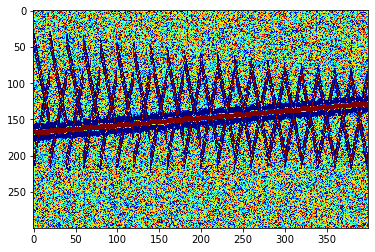

In [2]:
## Adding noise

np.random.seed(202223);
[n1,n2,n3]=dc.shape;
dn=dc+0.1*np.random.randn(n1,n2,n3)

# plotting the data as a 2D matrix
plt.figure(); 
plt.imshow(dn.reshape(300,20*20,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto')



SNRs before and after simple Fourier thresholding denoising are 6.9903 and 14.1503



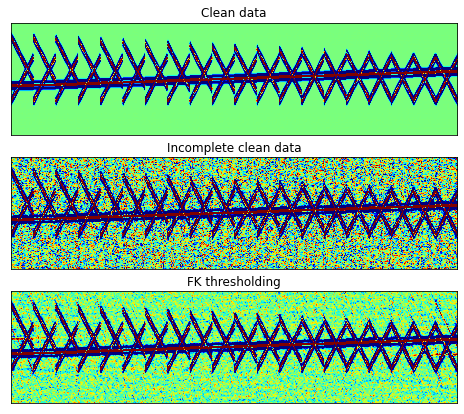

In [3]:
## Simple denoising
def csign(x):
    #sign function for complex value
    return x/(abs(x)+0.00000000001)
    
## define the thresholding function
def pthresh(x,sorh='ps',t=5):
    y=x.copy()
    import numpy as np
    if sorh == 's':
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
        ## HERE, very important, took very long to figure out the problem
        ## Cannot use numpy.sign because:
        ## There is more than one definition of sign in common use for complex numbers. The definition used here (in numpy) is equivalent to x/sqrt(x*x) which is different from a common alternative, x/abs(x).
        
    elif sorh == 'h':
        y=x*(np.abs(x)>t);
    elif sorh == 'ps':
        tmp=np.abs(x).flatten();
        t=np.percentile(tmp,100-t);
        thr=t;
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
            
    elif sort == 'ph':
        tmp=np.abs(x).reshape(1,x.size);
        t=np.percentile(tmp,100-t);
        thr=t;
        y=x*(np.abs(x)>t);
    else:
        print('Invalid argument value.');
    return y

def fkt(D,sorh='ps',thr=5):
    from scipy.fft import fftn,ifftn
    D1=ifftn(pthresh(fftn(D),sorh,thr));
    D1=np.real(D1);
    return D1

def snr(g,f):
    '''
    SNR: calculate the signal-to-noise ratio (SNR)
    '''
    import numpy as np
    psnr = 20.*np.log10(np.linalg.norm(g[:])/np.linalg.norm(g[:]-f[:]));
    return psnr

dnfk=fkt(dn,'ps',50);

# import scipy
# from scipy import io
# datas = {"dn":dn,'dnfk':dnfk,'dnfft':fftn(dn),'dnfftthr':pthresh(fftn(dn),'ps',50),'t':np.percentile(np.abs(fftn(dn)).flatten(),50),'test':pthresh(fftn(dn),'s',29.8539)}
# scipy.io.savemat("datas_fkthr.mat", datas)

print("SNRs before and after simple Fourier thresholding denoising are %g and %g\n"%(snr(dc,dn),snr(dc,dnfk)))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(dn.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow(dnfk.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('FK thresholding');

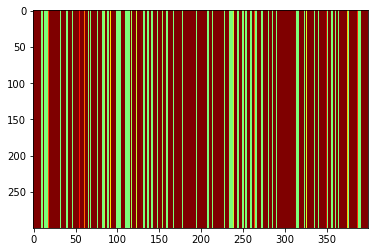

In [4]:
## Create sampling operator (mask)
ratio=0.5;
mask=pd.genmask(dn.reshape(n1,n2*n3,order='F'),ratio,'c',201415);
mask=mask.reshape(n1,n2,n3,order='F');

## decimate traces and create incomplete data
d0=dc*mask;

plt.figure(); 
plt.imshow(mask.reshape(300,20*20,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto')



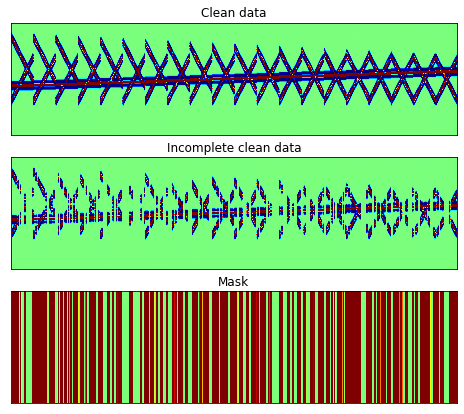

In [5]:
fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow((mask).transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Mask');

plt.show()


In [6]:
def csign(x):
    #sign function for complex value
    return x/(abs(x)+0.00000000001)
    
## define the thresholding function
def pthresh(x,sorh='ps',t=5):
    y=x.copy()
    import numpy as np
    if sorh == 's':
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
        ## HERE, very important, took very long to figure out the problem
        ## Cannot use numpy.sign because:
        ## There is more than one definition of sign in common use for complex numbers. The definition used here (in numpy) is equivalent to x/sqrt(x*x) which is different from a common alternative, x/abs(x).
        
    elif sorh == 'h':
        y=x*(np.abs(x)>t);
    elif sorh == 'ps':
        tmp=np.abs(x).flatten();
        t=np.percentile(tmp,100-t);
        thr=t;
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
            
    elif sort == 'ph':
        tmp=np.abs(x).reshape(1,x.size);
        t=np.percentile(tmp,100-t);
        thr=t;
        y=x*(np.abs(x)>t);
    else:
        print('Invalid argument value.');
    return y

def fkt(D,sorh='ps',thr=5):
    from scipy.fft import fftn,ifftn
    D1=ifftn(pthresh(fftn(D),sorh,thr));
    D1=np.real(D1);
    return D1

def fk_pocs(D,D0,mask,thr,niter):
    '''
    D: observed data
    D0: initial guess
    mask: mask operator
    thr: threshold
    niter: number of iterations
    '''
    D1=D0;
    for ii in range(niter):
        D1=D*mask + (1-mask)*fkt(D1,sorh='ps',thr=thr);
        
    return D1

def snr(g,f):
    '''
    SNR: calculate the signal-to-noise ratio (SNR)
    '''
    import numpy as np
    psnr = 20.*np.log10(np.linalg.norm(g[:])/np.linalg.norm(g[:]-f[:]));
    return psnr

d_fk=fk_pocs(d0,np.zeros(d0.shape),mask,2,100);

## compare SNR
print('SNR of d0 is %g'%snr(dc.flatten(),d0.flatten()));
print('SNR of d_fk is %g'%snr(dc.flatten(),d_fk.flatten()));

import scipy
from scipy import io
datas = {"d0":d0,"dc":dc,'dfk':d_fk,"mask":mask}
scipy.io.savemat("datas3d.mat", datas)

SNR of d0 is 2.92968
SNR of d_fk is 15.0206


# Projection onto convex sets (POCS)


$\mathbf{d}_{obs} = \mathbf{M} \mathbf{d}$

The POCS method solves the above problem by

$\mathbf{d}_{n+1} =  \mathbf{M}\mathbf{d}_{obs} +  (\mathbf{I} - \mathbf{M}) \mathcal{F} \mathbf{T} \mathcal{F}^{-1} \mathbf{d}_{n}$,

where $\mathcal{F}$ and $\mathcal{F}^{-1}$ denote a pair of forward and inverse Fourier transform. 

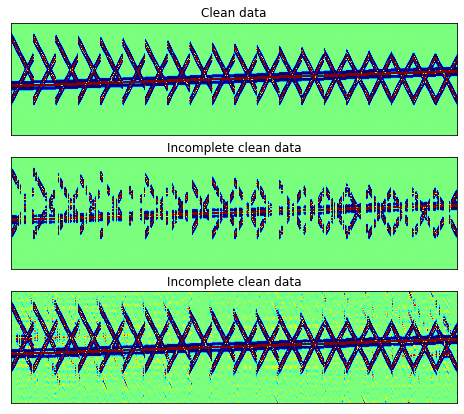

In [7]:

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');
ax=fig.add_subplot(3, 1, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');
ax=fig.add_subplot(3, 1, 3)
plt.imshow(d_fk.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');
plt.show()


# Projection onto convex sets (POCS) on noisy data

The inverse problem

$\mathbf{d}_{obs} = \mathbf{M} \mathbf{d}$

I: In the noiss-free case: the POCS method solves the above problem by

$\mathbf{d}_{n+1} =  \mathbf{M}\mathbf{d}_{obs} +  (\mathbf{I} - \mathbf{M}) \mathcal{F} \mathbf{T} \mathcal{F}^{-1} \mathbf{d}_{n}$,

where $\mathcal{F}$ and $\mathcal{F}^{-1}$ denote a pair of forward and inverse Fourier transform. 

II: In the noise-contaminated case: a weighted POCS method solves the above problem by

$\mathbf{d}_{n+1} =  \alpha_n \mathbf{M}\mathbf{d}_{obs} +  (1-\alpha_n)\mathbf{M} \mathcal{F} \mathbf{T} \mathcal{F}^{-1} \mathbf{d}_{n} +  (\mathbf{I} - \mathbf{M}) \mathcal{F} \mathbf{T} \mathcal{F}^{-1} \mathbf{d}_{n}$,

where $\alpha_n$ is a linearly decreasing weighting factor (from 1 to 0), meaning that the observed noisy data are gradually given a decreasing weighting throughout the iterations.


0.24472818719725775
0.17176208519313502


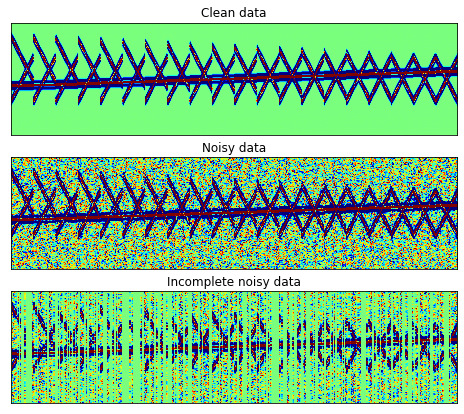

In [8]:

## add noise
[n1,n2,n3]=dc.shape
np.random.seed(201415)
n=0.1*np.random.randn(n1,n2,n3);
dn=dc+n;
print(np.std(dn))

## decimate traces
ratio=0.5;
mask=pd.genmask(dn.reshape(n1,n2*n3,order='F'),ratio,'c',201415);
mask=mask.reshape(n1,n2,n3,order='F');
d0=dn*mask;
print(np.std(d0))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(dn.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');

plt.show()

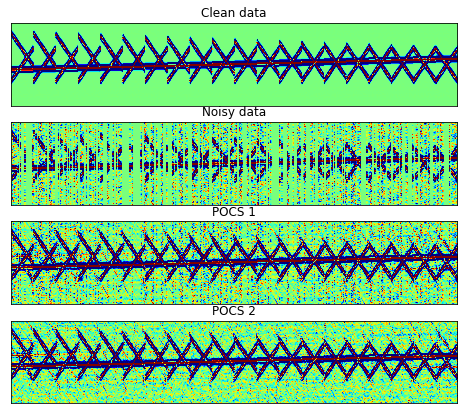

SNR of d_fk1 is 8.4998
SNR of d_fk2 is 11.8644


In [9]:
# Interpolation of noisy data
def fk_pocs(D,D0,mask,thr,niter):
    '''
    D: observed data
    D0: initial guess
    mask: mask operator
    thr: threshold
    niter: number of iterations
    '''
    D1=D0;
    for ii in range(niter):
        D1=D*mask + (1-mask)*fkt(D1,sorh='ps',thr=thr);
        
    return D1


def fk_pocs_n(D,D0,mask,thr,niter):
    '''
    D: observed data
    D0: initial guess
    mask: mask operator
    thr: threshold
    niter: number of iterations
    '''
    D1=D0;
    a=np.linspace(1,0,niter);
    for ii in range(niter):
        D1=a[ii]*D*mask + (1-a[ii])*mask*fkt(D1,sorh='ps',thr=thr) + (1-mask)*fkt(D1,sorh='ps',thr=thr);
        
    return D1

d_fk1=fk_pocs(d0,np.zeros(d0.shape),mask,2,100);
d_fk2=fk_pocs_n(d0,np.zeros(d0.shape),mask,30,100);

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(4, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(4, 1, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');

ax=fig.add_subplot(4, 1, 3)
plt.imshow(d_fk1.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('POCS 1');

ax=fig.add_subplot(4, 1, 4)
plt.imshow(d_fk2.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('POCS 2');
plt.show()

## compare SNR
print('SNR of d_fk1 is %g'%snr(dc.flatten(),d_fk1.flatten()));
print('SNR of d_fk2 is %g'%snr(dc.flatten(),d_fk2.flatten()));


# Compare the sparsity in the Fourier domain (3D FFT domain)


In [10]:
## Sparse reconstruction using Fourier transform
from scipy.fft import fftn,ifftn
import scipy.fft

dc_fftn=fftn(dc);
dn_fftn=fftn(dn);
d0_fftn=fftn(d0);

d_fk1_fftn=fftn(d_fk1);
d_fk2_fftn=fftn(d_fk2);


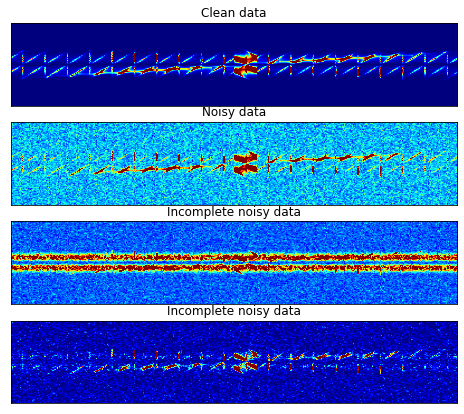

In [11]:
dc_fftn_abs=np.abs(scipy.fft.fftshift(dc_fftn))
dn_fftn_abs=np.abs(scipy.fft.fftshift(dn_fftn))
d0_fftn_abs=np.abs(scipy.fft.fftshift(d0_fftn))

d_fk2_fftn_abs=np.abs(scipy.fft.fftshift(d_fk2_fftn))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(4, 1, 1)
plt.imshow(dc_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(4, 1, 2)
plt.imshow(dn_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');

ax=fig.add_subplot(4, 1, 3)
plt.imshow(d0_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');

ax=fig.add_subplot(4, 1, 4)
plt.imshow(d_fk2_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');

plt.show()

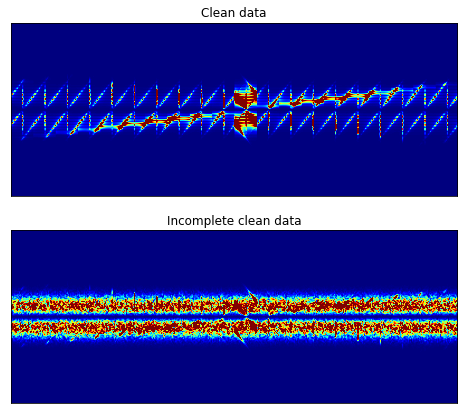

In [26]:
# Even without noise, the irregularly missing traces will still make the FK spectrum not sparse. 

dc_fftn_abs=np.abs(scipy.fft.fftshift(fftn(dc)))
dc0_fftn_abs=np.abs(scipy.fft.fftshift(fftn(dc*mask)))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(2, 1, 1)
plt.imshow(dc_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(2, 1, 2)
plt.imshow(dc0_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');

plt.show()


# Reconstruction using more advanced methods (Rank-based)


# 1. Hankel matrix embedding

The rank-reduction based methods discussed here deal with a block Hankel matrix (Inline and Xline) in the frequency-space domain. Let $\mathbf{D}(t,x,y)$ (of size $N_t\times N_x\times N_y$) represent a 3D seismic dataset. First, we transform $\mathbf{D}(t,x,y)$ in time-space domain to $\mathbf{D}(w,x,y)(w=1\cdots N_w)$ in the frequency-space domain. At a given frequency $w_0$ slice, the 2D data can be expressed as:

\begin{equation}
\label{eq:mssa3d} 
\mathbf{D}(w_0)=\left(\begin{array}{cccc}
D(1,1) & D(1,2) & \cdots &D(1,N_y) \\
D(2,1) & D(2,2)  &\cdots &D(2,N_y) \\
\vdots & \vdots &\ddots &\vdots \\
D(N_x,1)&D(N_x,2) &\cdots&D(N_x,N_y)
\end{array}
\right). 
\end{equation}

From here on, $w_0$ is omitted for notational convenience. A Hankel matrix is then constructed from $\mathbf{D}$. We first construct a Hankel matrix $\mathbf{R}_i$ as:

\begin{equation}
\label{eq:data}
\mathbf{R}_i=\left(\begin{array}{cccc}
D(i,1) & D(i,2) & \cdots &D(i,m) \\
D(i,2) & D(i,3)  &\cdots &D(i,m+1) \\
\vdots & \vdots &\ddots &\vdots \\
D(i,N_y-m+1)&D(i,N_y-m+2) &\cdots&D(i,N_y)
\end{array}
\right),
\end{equation}

and then construct the block Hankel matrix as:

\begin{equation}
\label{eq:hankel2}
\mathbf{M}=\left(\begin{array}{cccc}
\mathbf{R}_1 &\mathbf{R}_2 & \cdots &\mathbf{R}_n \\
\mathbf{R}_2 &\mathbf{R}_3 &\cdots &\mathbf{R}_{n+1} \\
\vdots & \vdots &\ddots &\vdots \\
\mathbf{R}_{N_x-n+1}&\mathbf{R}_{N_x-n+2} &\cdots&\mathbf{R}_{N_x}
\end{array}
\right).
\end{equation}

Parameters $m$ and $n$ are chosen to make $\mathbf{R}_i$ and $\mathbf{M}$ close to square matrices, e.g., $m=N_y-\lfloor\frac{N_y}{2}\rfloor$ and $n=N_x-\lfloor\frac{N_x}{2}\rfloor$. The symbol $\lfloor\cdot \rfloor$ outputs the integer of an input value. The matrix $\mathbf{M}$ is of size $I\times J$, with $I=(N_y-m+1)(N_x-n+1)$, $J=mn$. The block Hankel matrix $\mathbf{M}$ is considered to be lowrank, i.e., it can be approximated by a small number of eigen-images. 

# 2. Rank-reduction method

Regularization can be implemented as a rank-based constraint:

\begin{equation}
\label{eq:regu2}
\begin{split}
\hat{\mathbf{X}} &= \arg \min_{\mathbf{x}} \parallel\mathbf{D}-\mathbf{X} \parallel_F^2, \\ \text{subject to}&\quad \text{rank} (\mathcal{H}(\mathbf{X})) =N,
\end{split}
\end{equation}

where $\parallel\cdot\parallel_F$ denotes the Frobenius norm. $\mathbf{D}$ denotes a matrix constructed from the frequency slice corresponding to $w_0$. $\mathbf{X}$ denotes the noise-free data to be estimated. $\hat{\mathbf{X}}$ denotes the estimated signal. $\mathcal{H}(\mathbf{X})$ denotes the Hankel matrix constructed from $\mathbf{X}$. Let $\mathbf{M}=\mathcal{H}(\mathbf{D})$, the singular value decomposition of $\mathbf{M}$ can be expressed as 

\begin{equation}
\label{eq:svd}
\mathbf{M} = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^H,
\end{equation}

where $\mathbf{U}$ and $\mathbf{V}$ are referred to as the left and right singular vector matrices, respectively. $\boldsymbol{\Sigma}$ is the singular value matrix. $(\cdot)^H$ denotes complex tranpose. The rank of the signal component that is embedded in the Hankel matrix $\mathbf{M}$ is assumed to be $N$. The traditional rank-reduction method based on the truncated singular value decomposition (TSVD) can be briefly expressed as

\begin{equation}
\label{eq:tsvd}
\hat{\mathbf{S}} = \mathbf{U}_N\boldsymbol{\Sigma}_N\mathbf{V}_N^H,
\end{equation}

which is a solution to the optimization problem according to the Eckart-Young-Mirsky (EYM) theorem. $\hat{\mathbf{S}}$ denotes the denoised signal. $\mathbf{U}_N$ and $\mathbf{V}_N$ are matrices composed of the left $N$ singular vectors in $\mathbf{U}$ and $\mathbf{V}$, respectively. $\boldsymbol{\Sigma}_N$ is the truncated singular value matrix with the first $N$ singular values preserved.  Although theoretically $N$ equals to the number of distinct dipping components, it is practically defined as a relatively large number considering data complexity, otherwise signal energy can be damaged. 

# 3. Rank-based reconstruction
Introducing the sampling operator $\mathbf{M}$, we have
\begin{equation}
\label{eq:regu3}
\begin{split}
\hat{\mathbf{X}} &= \arg \min_{\mathbf{x}} \parallel\mathbf{D}_{obs}-\mathbf{M}\mathbf{X} \parallel_F^2, \\ \text{subject to}&\quad \text{rank} (\mathcal{H}(\mathbf{X})) =N,
\end{split}
\end{equation}

We use the similar weighted-POCS algorithm to solve this problem:

\begin{equation}
\label{eq:dmssapocs}
\mathbf{X}_n=a_n \mathbf{D}_{obs} + (1-a_n\mathcal{M})\circ \mathcal{R}\mathbf{X}_{n-1},\qquad n=1,2,3,\cdots,n_{max}
\end{equation}

where $\mathcal{R}$ is a cascaded operator chain combining Hankelization, TSVD, and de-Hankelization. 



In [12]:
# import numpy as np
import pydrr as pd

## Recon
flow=0;fhigh=125;dt=0.004;N=3;NN=3;Niter=10;mode=1;a=np.linspace(1,0,10);verb=1;eps=0.00000000001;
d1=pd.drr3drecon(d0,mask,flow,fhigh,dt,N,100,Niter,eps,mode,a,verb);
d2=pd.drr3drecon(d0,mask,flow,fhigh,dt,N,NN,Niter,eps,mode,a,verb);
noi1=dc-d1;
noi2=dc-d2;



flow= 0 fhigh= 125 dt= 0.004 N= 3 K= 100 Niter= 10 eps= 1e-11 mode= 1 verb= 1
mask.shape (20, 20)
F 5 is done!
F 10 is done!
F 15 is done!
F 20 is done!
F 25 is done!
F 30 is done!
F 35 is done!
F 40 is done!
F 45 is done!
F 50 is done!
F 55 is done!
F 60 is done!
F 65 is done!
F 70 is done!
F 75 is done!
F 80 is done!
F 85 is done!
F 90 is done!
F 95 is done!
F 100 is done!
F 105 is done!
F 110 is done!
F 115 is done!
F 120 is done!
F 125 is done!
F 130 is done!
F 135 is done!
F 140 is done!
F 145 is done!
F 150 is done!
F 155 is done!
F 160 is done!
F 165 is done!
F 170 is done!
F 175 is done!
F 180 is done!
F 185 is done!
F 190 is done!
F 195 is done!
F 200 is done!
F 205 is done!
F 210 is done!
F 215 is done!
F 220 is done!
F 225 is done!
F 230 is done!
F 235 is done!
F 240 is done!
F 245 is done!
F 250 is done!
F 255 is done!
flow= 0 fhigh= 125 dt= 0.004 N= 3 K= 3 Niter= 10 eps= 1e-11 mode= 1 verb= 1
mask.shape (20, 20)
F 5 is done!
F 10 is done!
F 15 is done!
F 20 is done!
F 25 i

In [13]:
## compare SNR
print('SNR of RR is %g'%pd.snr(dc,d1,2));
print('SNR of DRR is %g'%pd.snr(dc,d2,2));


print('SNR of RR is %g'%snr(dc.flatten(),d1.flatten()));
print('SNR of DRR is %g'%snr(dc.flatten(),d2.flatten()));

SNR of RR is 16.6763
SNR of DRR is 18.8706
SNR of RR is 16.6763
SNR of DRR is 18.8706


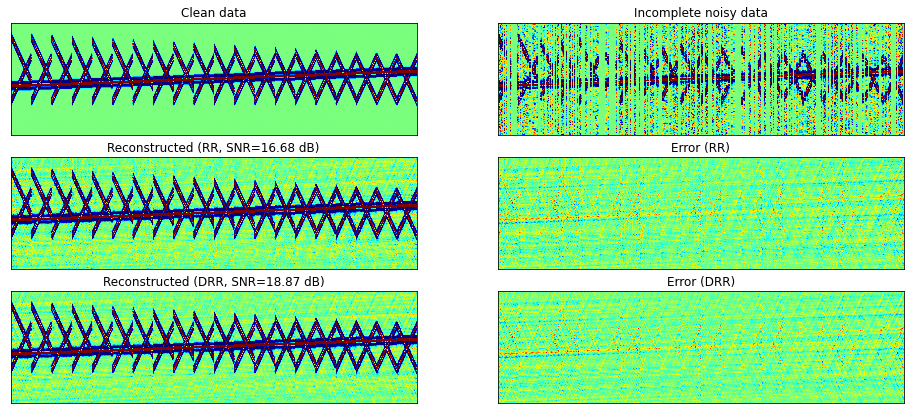

In [14]:

## plotting
fig = plt.figure(figsize=(16, 7))
ax=fig.add_subplot(3, 2, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');
ax=fig.add_subplot(3, 2, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');
ax=fig.add_subplot(3, 2, 3)
plt.imshow(d1.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Reconstructed (RR, SNR=%.4g dB)'%pd.snr(dc,d1,2));
ax=fig.add_subplot(3, 2, 4)
plt.imshow(noi1.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Error (RR)');
ax=fig.add_subplot(3, 2, 5)
plt.imshow(d2.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Reconstructed (DRR, SNR=%.4g dB)'%pd.snr(dc,d2,2));
ax=fig.add_subplot(3, 2, 6)
plt.imshow(noi2.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Error (DRR)');
plt.savefig('test_pydrr_drr3drecon.png',format='png',dpi=300);
plt.show()


In [15]:
np.abs(1+1j)

1.4142135623730951

# Revisiting the Radon-based reconstruction

In [16]:
## creating the radon doman coefficients (sparse)

def ricker(f,dt,tlength=None):
    # ricker: Ricker wavelet of central frequency f.
    #
    # INPUT:
    # f : central freq. in Hz (f <<1/(2dt) )
    # dt: sampling interval in sec
    # tlength : the duration of wavelet in sec
    #
    # OUTPUT: 
    # w:  the Ricker wavelet
    # tw: time axis
    #
    # Example
    #
    #   [w,tw] = ricker(10,0.004,0.2);
    #   pyplot.plot(tw,w);
    import numpy as np
    
    if tlength!=None:
        nw=np.floor(tlength/dt)+1;
    else:
        nw=2.2/f/dt;
        nw=2*np.floor(nw/2)+1;
    nc=np.floor(nw/2);
    nw=int(nw)
    w =np.zeros(nw);
    
    k=np.arange(1,nw+1,1);
    alpha = (nc-k+1)*f*dt*np.pi;
    beta=np.power(alpha,2);
    w = (1.-beta*2)*np.exp(-beta);
    tw = -(nc+1-k)*dt;
    return w,tw

import numpy as np

h=np.linspace(0,500,51);nh=len(h);
v=np.linspace(1300,2500,25);nv=len(v);

nt = 450;
dt=0.004;

m=np.zeros([nt,nv]);
d=np.zeros([nt,nh]);

w,tw=ricker(40,dt);

for it in range(0,nt,40):
    m[it,3] = np.random.randn(1,1);

import scipy.signal
w=np.expand_dims(w,1);
m=scipy.signal.convolve2d(m,w,'same');

par={'h':h,'v':v,'nt':nt,'dt':dt,'typ':3}




In [17]:
# forward Radon transform

import pyradon as pr

d=pr.radonc(m,par,1); #data

d=d+0.1*np.random.randn(d.shape[0],d.shape[1]); #adding noise

ma=pr.radonc(d,par,-1); #adjoint model





In [18]:
# Sparse inversion
N1=20;
N2=3;

mi_l1,misfit_l1 = pr.radon_l1c(par,d,np.zeros(ma.shape),N1,N2,1);

dp_l1=pr.radonc(mi_l1,par,1);


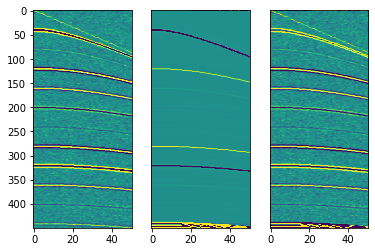

In [19]:
## compare results

plt.figure();

plt.subplot(1,3,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);
plt.subplot(1,3,2);
plt.imshow(dp_l1,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);
plt.subplot(1,3,3);
plt.imshow(d-dp_l1,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);



# Interpolate missing traces

In [20]:
## create indices missing trace
inds_mis1=np.linspace(10,15,5);
inds_mis2=np.linspace(26,35,10);
inds_mis=np.concatenate([inds_mis1,inds_mis2],axis=0);

d_mis=d.copy();

## create incomplete data
d_mis[:,np.int32(inds_mis)] = 0; #d_mis is for display only
d_mis_nozero=np.delete(d_mis,np.int32(inds_mis),axis=1);#delete the traces in the data

## create corresponding offset coordinates
h_mis=h;
h_mis=np.delete(h_mis,np.int32(inds_mis));


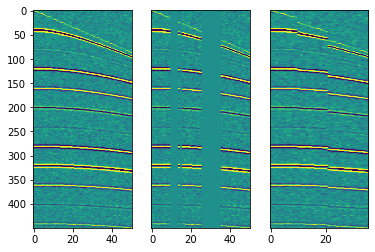

In [21]:
plt.figure();

plt.subplot(1,3,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);

plt.subplot(1,3,2);
plt.imshow(d_mis,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);

plt.subplot(1,3,3);
plt.imshow(d_mis_nozero,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);


Text(0.5, 1.0, 'Error/Noise')

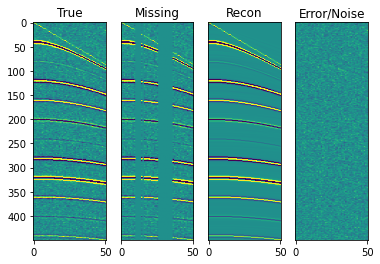

In [22]:
## change the parameter object
par['h']=h_mis; 

m_mis_l1,misfit=pr.radon_l1c(par,d_mis_nozero,np.zeros(ma.shape),N1,N2,1);

#m_mis_l1 is the inverted Radon domain from incomplete data
#for reconstruction, we need a complete offset coordinate vector
par['h']=h;
d_recon = pr.radonc(m_mis_l1,par,1);


plt.figure();

plt.subplot(1,4,1);
plt.imshow(d,aspect='auto',clim=[-0.5,0.5]);plt.title('True')

plt.subplot(1,4,2);
plt.imshow(d_mis,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Missing')

plt.subplot(1,4,3);
plt.imshow(d_recon,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Recon')

plt.subplot(1,4,4);
plt.imshow(d-d_recon,aspect='auto',clim=[-0.5,0.5]);plt.gca().set_yticks([]);plt.title('Error/Noise')
